## Author Quote Model Notebook

In [18]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.feature_selection import SelectFpr, SelectKBest
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mlxtend.preprocessing import DenseTransformer
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix

from gensim import corpora, models
import pyLDAvis.gensim

import glob
import os

### Helper functions for accessing datasets, running gridsearch pipelines and reviewing model results

In [14]:
def create_datasets_from_csv_files(directory_):
    path = directory_
    print('path=', path)
    allFiles = glob.glob(path + '/*.csv')
    file_dict = {}
    for file_ in allFiles:
        filename = file_.split('/')[2].split('.')[0]
        df = pd.read_csv(file_,index_col=None, header=0)
        file_dict[filename] = df
    return file_dict

dataset_dict = create_datasets_from_csv_files('../datasets')
print("Available datasets:", dataset_dict.keys())

path= ../datasets
Available datasets: dict_keys(['authors', 'bible', 'bible_target', 'mark_twain', 'quotes', 'script_org_sw_proverbs', 'scripture', 'scripture_original_sw', 'twain_target'])


In [19]:
def run_gridsearch_pipeline(stages, params, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(stages)
    estimator = GridSearchCV(pipeline, params)
    estimator.fit(X_train, y_train)
    
    print("Best params = ", estimator.best_params_)
    print("Best score = ", estimator.best_score_)
    preds = estimator.predict(X_test)
    print('Accuracy score = ', accuracy_score(y_test, preds))
    return estimator

In [20]:
def store_pipeline_results(estimator_, model, dataset_name, text_description, X_test, y_test, df):
    results = estimator_.best_params_
    results['model'] = model
    results['dataset'] = dataset_name
    results['ml_steps'] = list(estimator_.best_estimator_.named_steps)
    results['text_description'] = text_description
    results['best_score'] = estimator_.best_score_
    results['estimator_score']  = estimator_.score(X_test, y_test)
    df = df.append(results, ignore_index=True)
    return df

In [21]:
def model_topic(quotes, num_topics_=5, passes_ = 5, min_proba=.5):
    dictionary = corpora.Dictionary(quotes)
    
    corpus = [dictionary.doc2bow(q) for q in quotes]
    
    ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = num_topics_, 
                                        passes = passes_, 
                                        minimum_probability=min_proba)  
    return ldamodel, corpus, dictionary 

In [22]:
def find_top_models(df_model_data, dataset, model=None, limit=3):
    if df_model_data.empty:
        print("Modeling dataframe is empty. Trying run some gridsearches...")
        return
    else: 
        group_by_ = ["model", "dataset", "estimator_score", "text_description", "ml_steps"]
        dataset_filter = df_model_data["dataset"].str.lower() == dataset.lower()
        
        if model is None:
            filter_ = dataset_filter
        else:
            filter_ = (dataset_filter) & (df_model_data["model"].str.lower() == model.lower())
            
        df_scores = pd.DataFrame(df_model_data[filter_].groupby(group_by_).size()).reset_index()
   
        return df_scores.sort_values('estimator_score', ascending=False).head(limit)

In [32]:
gridsearch_dir = "../gridsearch_results/"
if not os.path.exists(gridsearch_dir ):
    os.makedirs(gridsearch_dir )
    print(gridsearch_dir , ' created!')
    df_gs_results = pd.DataFrame()
else:
    df_gs_results = (create_datasets_from_csv_files(gridsearch_dir))["gs_results"]
    
df_gs_results.head(1)

path= ../gridsearch_results/


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
0,0.886306,scripture,0.9,multinomial,newton-cg,"['vec', 'logit']",LogisticRegression,no_stopwords,0.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Top models for scriptures

df_top_smodels = find_top_models(df_gs_results, "scripture")

# Top scores for specific model (i.e "MultinomialNB", LogisticRegression", "RandomForestClassifier")
#df_top_smodels = find_top_models(df_gs_results, "scripture", "RandomForestClassifier", 3)

df_top_smodels

,model,dataset,estimator_score,text_description,ml_steps,0
11,MultinomialNB,scripture,0.945455,no_stopwords,"['vec', 'mnclf']",3
10,LogisticRegression,scripture,0.931818,lemmatized,"['cvec', 'logit']",3
9,LogisticRegression,scripture,0.918182,lemmatized,"['cvec', 'todense', 'pca', 'logit']",1


In [24]:
# Top models for authors
df_top_amodels = find_top_models(df_gs_results, "authors", None, 5)

# Top scores for specific model (i.e "MultinomialNB", LogisticRegression", "RandomForestClassifier")
#df_top_amodels = find_top_models(df_gs_results, "authors", "LogisticRegression", 3)

df_top_amodels

,model,dataset,estimator_score,text_description,ml_steps,0
10,MultinomialNB,authors,0.604331,no_stopwords,"['cvec', 'mnclf']",2
9,MultinomialNB,authors,0.602362,stemmed,"['cvec', 'mnclf']",1
8,MultinomialNB,authors,0.600394,lemmatized,"['cvec', 'mnclf']",1
7,MultinomialNB,authors,0.598425,no_stopwords,"['vec', 'mnclf']",1
6,MultinomialNB,authors,0.594488,lemmatized,"['vec', 'mnclf']",1


### Set Random Seed for Model consitency

In [25]:
# make sure we get reproducible results
# needed because models are generated from random selection of words
np.random.seed(42)

### Modeling Scripture Quotes

In [26]:
df_script = dataset_dict['scripture']
#dataset_dict['scripture_original_sw']
#dataset_dict['scripture']
print(df_script.shape)
df_script.head(2)

(2199, 5)


,author,quote,no_stopwords,lemmatized,stemmed
0,Bible Bible,"And Adam was not deceived, but the woman being...",Adam deceived woman deceived transgression,Adam deceive woman deceive transgression,adam deceiv woman deceiv transgress
1,Bible Bible,All these trust to their hands: and every one ...,trust hands every one wise work,trust hand every one wise work,trust hand everi one wise work


In [27]:
df_smodel = df_script.copy()
lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_smodel['author'].values)) 
df_smodel['auth_label'] = lbl.transform(df_smodel['author'].values)
print("Verify Author labels:", df_smodel['auth_label'].unique())

Verify Author labels: [0 2 1]


In [28]:
df_smodel.groupby(['author', 'auth_label']).size()

author        auth_label
Bible Bible   0             1139
Granth Sahib  1              574
quran quran   2              486
dtype: int64

In [29]:
baseline = df_smodel['author'].value_counts().values[0]/df_smodel.shape[0]
print('Baseline =', baseline)

Baseline = 0.517962710323


#### Bayes MultinomialNB

In [33]:
stages_ = [('vec', TfidfVectorizer()), ('mnclf', MultinomialNB())] #TfidfVectorizer()
    
params_ = dict(
    vec__max_features=[None, 1000, 2000], 
    vec__lowercase=[True, False],
    vec__max_df=[0.5, 1.0],
    #vec__min_df=[0.01, 0.02, 1],
    vec__ngram_range=[(1,1),(1,2)],
    mnclf__fit_prior=[True, False],
    mnclf__alpha=[.05, 0.1, 0.2]
)

data_desc = 'no_stopwords'
X = df_smodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_smodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator = run_gridsearch_pipeline(stages_, params_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator,'MultinomialNB', 
                                                 'scripture', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'mnclf__alpha': 0.2, 'mnclf__fit_prior': False, 'vec__lowercase': False, 'vec__max_df': 0.5, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
Best score =  0.931278423446
Accuracy score =  0.945454545455


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
50,0.931278,scripture,0.945455,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,no_stopwords,0.0,0.5,...,NaN,NaN,0.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
51,0.507440,authors,0.604331,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,1.0,NaN,NaN,NaN,NaN
52,0.931278,scripture,0.945455,NaN,NaN,"[vec, mnclf]",MultinomialNB,no_stopwords,0.0,0.5,...,NaN,NaN,0.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Review Prediction Probabilites for a given model

In [604]:
predict_proba_ = estimator.predict_proba(X_test)
y_preds = estimator.predict(X_test)
proba_df = pd.DataFrame(predict_proba_, columns = ['prob_bible','prob_granth','prob_quran']).reset_index(drop=True)
quote_df = pd.DataFrame(list(X_test), columns=['quote']).reset_index(drop=True)
pred_df = pd.DataFrame(list(y_preds), columns=['author_prediction']).reset_index(drop=True)
author_df = pd.DataFrame(list(y_test), columns=['author_label']).reset_index(drop=True)
#y_test.to_frame().reset_index(drop=True)
df_predictions = pd.concat([proba_df, quote_df, author_df, pred_df ], axis = 1)
df_predictions.head()

,prob_bible,prob_granth,prob_quran,quote,author_label,author_prediction
0,0.962159,0.006014,0.031827,Joseph saw Benjamin said ruler house Bring men...,0,0
1,0.533405,0.174383,0.292212,Set affection things things earth Colossians 3 2,0,0
2,0.877100,0.038330,0.084569,riches might dwell together land wherein stran...,0,0
3,0.224860,0.571934,0.203206,pleases play music sing pleases bathe water,1,1
4,0.964565,0.012723,0.022713,shall return land Egypt Assyrian shall king re...,0,0


In [653]:
test = pd.DataFrame(y_test, columns=['y'])
test.y.value_counts()

0    124
1     54
2     42
Name: y, dtype: int64

In [654]:
test2 = pd.DataFrame(y_preds, columns=['y_preds'])
test2.y_preds.value_counts()

0    130
1     54
2     36
Name: y_preds, dtype: int64

Predicted     Bible  Granth Sahib  Quran  __all__
Actual                                           
Bible           121             2      1      124
Granth Sahib      2            52      0       54
Quran             7             0     35       42
__all__         130            54     36      220


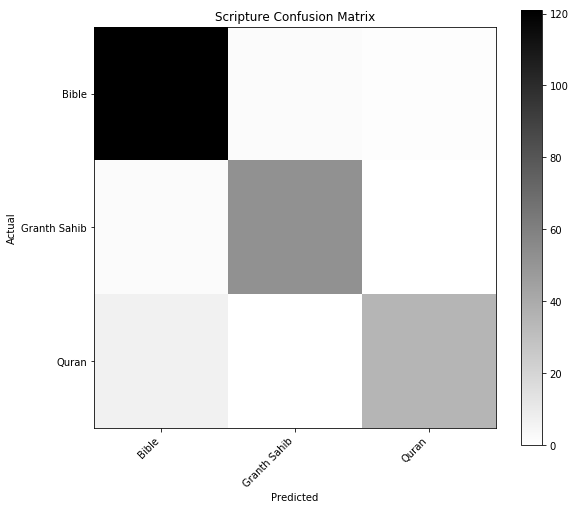

In [655]:
labels = ['Bible', 'Granth Sahib', 'Quran']
cm = ConfusionMatrix(y_test, y_preds, labels)
print(cm)

cm.plot()

plt.title('Scripture Confusion Matrix')
plt.show();

#### Review quotes for incorrect predictions

In [363]:
df_predictions[df_predictions['author_label'] != df_predictions['author_prediction']]

,prob_bible,prob_granth,prob_quran,quote,author_label,author_prediction
11,0.409812,0.221262,0.368925,came evil generation neglected prayers followe...,2,0
46,0.582111,0.288366,0.129524,relish delight continually bite bait trapped f...,1,0
64,0.076119,0.719795,0.204086,pride comes comes disgrace humility comes wisdom,0,1
66,0.850386,0.107239,0.042375,wife yearns gold silver friends senses yearn g...,1,0
67,0.154223,0.597512,0.248265,wait wind weather right never plant anything n...,0,1
72,0.721843,0.135790,0.142367,bowl shall made go round water running springs...,2,0
76,0.724102,0.135226,0.140672,Prayer carries us half way God fasting brings ...,2,0
96,0.470003,0.104623,0.425375,sold small price pieces silver showed desire,2,0
134,0.665707,0.095211,0.239082,shall see shall see afflicted madness,2,0
158,0.370079,0.179388,0.450533,wounded transgressions bruised iniquities chas...,0,2


#### Testing the model against flash dataset of about 12 Bible quotes?   

How did it perform?  It baselined getting only 6 predictions correct.

In [582]:
df_bible_test = dataset_dict['bible_target']
desc = "no_stopwords" #"lemmatized" #"no_stopwords"
X_test2 = df_bible_test[desc] # results differ a bit depending on no_stopwords, lemmatized, or stemmed

y_preds2 = estimator.predict(X_test2)
    
predict_proba2_ = estimator.predict_proba(X_test2)
proba2_df = pd.DataFrame(predict_proba2_, columns = ['prob_bible','prob_granth','prob_quran']).reset_index(drop=True)
pred2_df = pd.DataFrame(list(y_preds2), columns=['author_prediction']).reset_index(drop=True)
pd.concat([proba2_df, df_bible_test[["author", desc]], pred2_df ], axis = 1)

,prob_bible,prob_granth,prob_quran,author,no_stopwords,author_prediction
0,0.387435,0.480418,0.132148,Bible Bible,clothed strength dignity laughs without fear f...,1
1,0.250971,0.696775,0.052254,Bible Bible,pain feeling compare joy coming,1
2,0.181718,0.572585,0.245697,Bible Bible,bold brave courageous,1
3,0.485137,0.194057,0.320806,Bible Bible,time everything reason every activity heavens,0
4,0.701112,0.100078,0.198810,Bible Bible,afraid discouraged God strengthen help hold vi...,0
5,0.722045,0.117413,0.160542,Bible Bible,cover feathers wings find refuge faithfulness ...,0
6,0.566583,0.382475,0.050942,Bible Bible,soul finds rest God alone salvation comes alon...,0
7,0.360784,0.480930,0.158286,Bible Bible,everything Christ gives strength,1
8,0.216498,0.518311,0.265191,Bible Bible,cause pain without allowing something new born...,1
9,0.670061,0.230680,0.099259,Bible Bible,go deep waters,0


#### RandomForestClassification

In [332]:
stages_ = [('cvec', CountVectorizer()), ('rfclf', RandomForestClassifier())] #TfidfVectorizer()
    
params_ = dict(
    cvec__max_features=[None, 1000, 2000, 5000], 
    cvec__lowercase=[True, False],
    cvec__max_df=[0.5, 1.0],
    #vec__min_df=[0.01, 0.02, 1],
    cvec__ngram_range=[(1,1),(1,2)],
    rfclf__criterion = ['gini', 'entropy'],
    rfclf__max_features = [0.01, 0.25, 0.50],
    rfclf__n_estimators = [10, 15, 20]
)

data_desc = "no_stopwords"
X = df_smodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_smodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator = run_gridsearch_pipeline(stages_, params_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator,'RandomForestClassifier', 
                                                 'scripture', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'cvec__lowercase': False, 'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'rfclf__criterion': 'gini', 'rfclf__max_features': 0.01, 'rfclf__n_estimators': 20}
Best score =  0.872662961091
Accuracy score =  0.85


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
42,0.854977,scripture,0.868182,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,lemmatized,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,NaN,NaN
43,0.853967,scripture,0.877273,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.01,10.0
44,0.870642,scripture,0.859091,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,15.0
45,0.859020,scripture,0.872727,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,entropy,0.01,15.0
46,0.872663,scripture,0.850000,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.01,20.0


#### Logistic Regression

In [287]:
stages2_ = [('cvec', CountVectorizer()), # include to remove sparse error
            #('denseto', DenseTransformer()),
            #('pca', decomposition.PCA()),
            ('logit', LogisticRegression())] # CountVectorizer, TfidfVectorizer
    
params2_ = dict(
    #pca__n_components=[700, 1000],
    #pca__svd_solver=['auto', 'arpack'],
    cvec__max_features=[None, 1000, 2000], 
    cvec__lowercase=[True, False],
    cvec__max_df=[0.5, 0.7, 1.0],
    cvec__min_df=[0.01, 0.02, 1],
    cvec__ngram_range=[(1,1),(1,2)],
    logit__multi_class= ['ovr', 'multinomial'],
    logit__solver= ['newton-cg','lbfgs']
)

data_desc = 'lemmatized'
X = df_smodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_smodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator2 = run_gridsearch_pipeline(stages2_, params2_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator2,'LogisticRegression', 
                                                 'scripture', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'cvec__lowercase': False, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'logit__multi_class': 'multinomial', 'logit__solver': 'newton-cg'}
Best score =  0.897928246589
Accuracy score =  0.931818181818


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,cvec__lowercase,cvec__max_df,cvec__max_features,cvec__ngram_range,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df
20,0.936837,scripture_org_sw_no_proverbs,0.936364,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,lemmatized,NaN,NaN,...,0.0,0.5,NaN,"(1, 1)",NaN,NaN,0.2,1.0,NaN,1.0
21,0.935321,scripture_org_sw_no_proverbs,0.927273,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,lemmatized,0.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,1.0,1.0,NaN
22,0.907024,scripture_org_sw_no_proverbs,0.909091,multinomial,newton-cg,"[cvec, logit]",LogisticRegression,lemmatized,NaN,NaN,...,0.0,0.7,2000,"(1, 1)",NaN,NaN,NaN,NaN,NaN,1.0
23,0.908034,scripture_org_sw_no_proverbs,0.918182,ovr,newton-cg,"[cvec, logit]",LogisticRegression,lemmatized,NaN,NaN,...,0.0,0.5,None,"(1, 1)",NaN,NaN,NaN,NaN,NaN,1.0
24,0.897928,scripture,0.931818,multinomial,newton-cg,"[cvec, logit]",LogisticRegression,lemmatized,NaN,NaN,...,0.0,0.5,None,"(1, 1)",NaN,NaN,NaN,NaN,NaN,1.0


### Modeling Author Quotes

In [289]:
df_auths = dataset_dict['authors']
print(df_auths.shape)
df_auths.head(2)

(5078, 5)


,author,quote,no_stopwords,lemmatized,stemmed
0,Ambrose Gwinett Bierce,"RECRUIT, n. A person distinguishable from a ci...",RECRUIT n person distinguishable civilian unif...,RECRUIT n person distinguishable civilian unif...,recruit n person distinguish civilian uniform ...
1,Ambrose Gwinett Bierce,"RANK, n. Relative elevation in the scale of hu...",RANK n Relative elevation scale human worth,RANK n Relative elevation scale human worth,rank n relat elev scale human worth


In [290]:
df_amodel = df_auths.copy()
lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_amodel['author'].values)) 
df_amodel['auth_label'] = lbl.transform(df_amodel['author'].values)
print("Verify Author labels:", df_amodel['auth_label'].unique())

Verify Author labels: [1 0 7 8 2 9 3 4 5 6]


In [679]:
df_amodel.groupby(["author", "auth_label"]).size()

author                       auth_label
Albert Einstein              0             485
Ambrose Gwinett Bierce       1             398
Friedrich Wilhelm Nietzsche  2             393
George Bernard Shaw          3             402
Henry David Thoreau          4             396
Mark Twain                   5             679
Oscar Wilde                  6             509
Ralph Waldo Emerson          7             888
Scott McClellan              8             354
William Shakespeare          9             574
dtype: int64

In [291]:
baseline = df_amodel['author'].value_counts().values[0]/df_amodel.shape[0]
print('Baseline =', baseline)

Baseline = 0.174871996849


#### Bayes MultinomialNB

In [677]:
stages_ = [('cvec', CountVectorizer()), ('mnclf', MultinomialNB())] #TfidfVectorizer()
    
params_ = dict(
    cvec__max_features=[None, 1000, 5000], 
    cvec__lowercase=[True, False],
    cvec__max_df=[0.5, 1.0],
    cvec__min_df=[0.01, 0.02, 1],
    cvec__ngram_range=[(1,1),(1,2)],
    mnclf__fit_prior=[True, False],
    mnclf__alpha=[0.1, 0.2, 0.5]
)

data_desc = 'no_stopwords'
X = df_amodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_amodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator = run_gridsearch_pipeline(stages_, params_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator,'MultinomialNB', 
                                                 'authors', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'cvec__lowercase': True, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'mnclf__alpha': 0.2, 'mnclf__fit_prior': True}
Best score =  0.507439824945
Accuracy score =  0.604330708661


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
49,0.431947,authors,0.503937,NaN,NaN,"['vec', 'rfclf']",RandomForestClassifier,no_stopwords,1.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.001,20.0
50,0.931278,scripture,0.945455,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,no_stopwords,0.0,0.5,...,NaN,NaN,0.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
51,0.507440,authors,0.604331,NaN,NaN,"[cvec, mnclf]",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,1.0,NaN,NaN,NaN,NaN


In [679]:
df_amodel.groupby(["author", "auth_label"]).size()

author                       auth_label
Albert Einstein              0             485
Ambrose Gwinett Bierce       1             398
Friedrich Wilhelm Nietzsche  2             393
George Bernard Shaw          3             402
Henry David Thoreau          4             396
Mark Twain                   5             679
Oscar Wilde                  6             509
Ralph Waldo Emerson          7             888
Scott McClellan              8             354
William Shakespeare          9             574
dtype: int64

In [680]:
cols = ['prob_einstein','prob_bierce','prob_nietzsche','prob_shaw',
        'prob_thoreau','prob_twain','prob_wilde','prob_emerson','prob_mcclellan', 'prob_shakespeare']
predict_proba_ = estimator.predict_proba(X_test)
y_preds = estimator.predict(X_test)
proba_df = pd.DataFrame(predict_proba_, columns = cols).reset_index(drop=True)
quote_df = pd.DataFrame(list(X_test), columns=['quote']).reset_index(drop=True)
pred_df = pd.DataFrame(list(y_preds), columns=['author_prediction']).reset_index(drop=True)
author_df = pd.DataFrame(list(y_test), columns=['author_label']).reset_index(drop=True)
df_apredictions = pd.concat([proba_df, quote_df, author_df, pred_df ], axis = 1)
df_apredictions.head()

,prob_einstein,prob_bierce,prob_nietzsche,prob_shaw,prob_thoreau,prob_twain,prob_wilde,prob_emerson,prob_mcclellan,prob_shakespeare,quote,author_label,author_prediction
0,0.023913,0.000712,9.257845e-01,3.400744e-07,5.087905e-05,2.930345e-04,4.863942e-02,0.000052,5.281015e-04,2.539920e-05,Talking much oneself also means conceal oneself,2,2
1,0.000059,0.002930,2.113690e-04,1.068432e-08,4.105720e-05,1.617115e-07,6.333032e-07,0.996677,2.510638e-11,8.202503e-05,Great men unknown generation fame among great ...,4,7
2,0.002832,0.991155,3.987051e-06,1.259827e-03,1.599242e-04,2.951732e-04,2.405127e-05,0.004269,3.341945e-07,8.212272e-07,PHRENOLOGY n science picking pocket scalp cons...,1,1
3,0.037112,0.014311,3.538431e-02,1.559712e-01,3.570148e-02,1.816594e-01,1.585766e-01,0.156589,8.474898e-02,1.399459e-01,use,7,5
4,0.000002,0.000001,9.301271e-07,1.825923e-07,8.998849e-07,5.296771e-05,1.388937e-07,0.000004,6.309118e-07,9.999376e-01,Sweet uses adversity,9,9


In [681]:
df_apredictions[df_apredictions['author_label'] != df_apredictions['author_prediction']]

,prob_einstein,prob_bierce,prob_nietzsche,prob_shaw,prob_thoreau,prob_twain,prob_wilde,prob_emerson,prob_mcclellan,prob_shakespeare,quote,author_label,author_prediction
1,5.852435e-05,2.929637e-03,2.113690e-04,1.068432e-08,4.105720e-05,1.617115e-07,6.333032e-07,9.966766e-01,2.510638e-11,8.202503e-05,Great men unknown generation fame among great ...,4,7
3,3.711178e-02,1.431108e-02,3.538431e-02,1.559712e-01,3.570148e-02,1.816594e-01,1.585766e-01,1.565893e-01,8.474898e-02,1.399459e-01,use,7,5
5,5.507947e-03,1.555661e-03,2.110696e-03,7.209069e-04,2.856822e-03,3.712881e-01,1.263401e-02,6.019714e-01,3.246440e-06,1.351199e-03,Every one master grief,9,7
10,9.966529e-07,9.999873e-01,1.125822e-05,7.946008e-08,9.174896e-08,8.167322e-09,2.977875e-07,9.399011e-09,4.004714e-10,4.865708e-10,country without rabbits partridges among simpl...,4,1
11,1.440245e-02,2.510636e-04,4.125861e-04,1.956218e-05,1.466656e-04,3.653722e-01,2.777293e-01,3.413830e-01,2.831747e-04,4.037246e-08,striking result present system farming nationa...,3,5
14,1.284770e-04,2.195709e-03,6.945355e-04,6.769273e-01,1.054729e-02,1.660966e-02,2.048292e-01,8.794751e-02,8.621894e-09,1.203370e-04,care flowers Calls rubbish tell one another th...,5,3
18,1.407906e-04,9.984309e-01,8.202555e-05,2.241914e-06,4.525332e-05,2.451225e-04,8.524365e-06,7.050114e-04,7.891452e-09,3.401078e-04,Ignorance curse God knowledge wing wherewith f...,9,1
19,8.303802e-01,2.959784e-04,6.879226e-03,1.447422e-02,7.404977e-05,5.644120e-02,6.369569e-02,2.706376e-02,2.658248e-04,4.297981e-04,hardest thing world think,7,0
20,2.395170e-07,2.300240e-06,4.048724e-04,3.126680e-05,4.422513e-05,2.027673e-04,4.099116e-04,1.050168e-02,6.942760e-09,9.884027e-01,Give love obey thy heart,7,9
23,1.373330e-02,9.529229e-02,3.297002e-02,9.679267e-03,1.402890e-02,3.239125e-01,1.270634e-04,5.018371e-01,6.725722e-03,1.693803e-03,E mc2 Energy equals mass times speed light squ...,0,7


Predicted         prob_bierce  prob_einstein  prob_emerson  prob_mcclellan  \
Actual                                                                       
prob_bierce                23              4             4               0   
prob_einstein               0             50             6               1   
prob_emerson                4              4            53               0   
prob_mcclellan              0              0             0              31   
prob_nietzsche              0              5             7               0   
prob_shakespeare            3              0            12               0   
prob_shaw                   2              1             7               0   
prob_thoreau                1              1            10               1   
prob_twain                  2              2            12               0   
prob_wilde                  1              2             5               0   
__all__                    36             69           116      

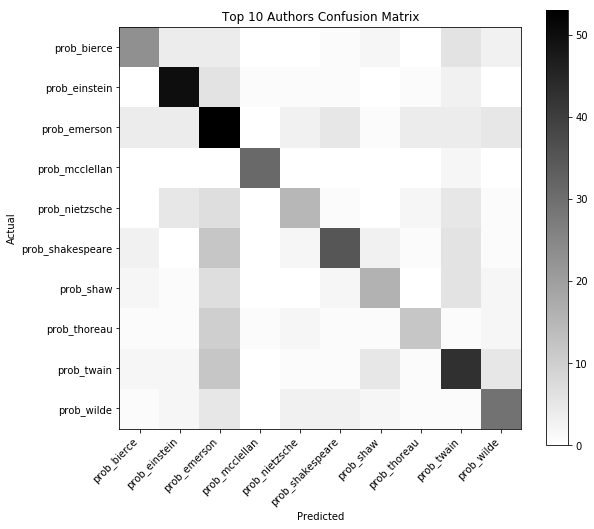

In [684]:
cm2 = ConfusionMatrix(y_test, y_preds, cols)
print(cm2)

cm2.plot()

plt.title('Top 10 Authors Confusion Matrix')
plt.show();

#### RandomForestClassifier

In [336]:
stages_ = [('vec', TfidfVectorizer()), ('rfclf', RandomForestClassifier())] #TfidfVectorizer()
    
params_ = dict(
    vec__max_features=[None, 2000, 5000], 
    vec__lowercase=[True, False],
    vec__max_df=[0.5, 1.0],
    #vec__min_df=[0.01, 0.02, 1],
    vec__ngram_range=[(1,1),(1,2)],
    rfclf__criterion = ['gini', 'entropy'],
    rfclf__max_features = [0.001, 0.005],
    rfclf__n_estimators = [15, 20]
)

data_desc = 'no_stopwords'
X = df_amodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_amodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator = run_gridsearch_pipeline(stages_, params_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator,'RandomForestClassifier', 
                                                 'authors', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'rfclf__criterion': 'gini', 'rfclf__max_features': 0.001, 'rfclf__n_estimators': 20, 'vec__lowercase': True, 'vec__max_df': 0.5, 'vec__max_features': None, 'vec__ngram_range': (1, 1)}
Best score =  0.431947483589
Accuracy score =  0.503937007874


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
45,0.859020,scripture,0.872727,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,entropy,0.010,15.0
46,0.872663,scripture,0.850000,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,no_stopwords,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.010,20.0
47,0.403501,authors,0.476378,NaN,NaN,"[cvec, rfclf]",RandomForestClassifier,lemmatized,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.010,10.0
48,0.414223,authors,0.511811,NaN,NaN,"[vec, rfclf]",RandomForestClassifier,no_stopwords,1.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.005,15.0
49,0.431947,authors,0.503937,NaN,NaN,"[vec, rfclf]",RandomForestClassifier,no_stopwords,1.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gini,0.001,20.0


In [676]:
df_gs_results[df_gs_results["dataset"] == "authors"].tail(15)

,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k,rfclf__criterion,rfclf__max_features,rfclf__n_estimators
25,0.509628,authors,0.598425,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,no_stopwords,1.0,0.5,...,NaN,NaN,0.1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
26,0.513567,authors,0.594488,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,lemmatized,1.0,0.5,...,NaN,NaN,0.1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
27,0.516193,authors,0.590551,NaN,NaN,"['vec', 'mnclf']",MultinomialNB,stemmed,NaN,0.5,...,NaN,NaN,0.1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
28,0.510503,authors,0.602362,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,stemmed,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,1.0,NaN,NaN,NaN,NaN
29,0.507440,authors,0.604331,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,1.0,NaN,NaN,NaN,NaN
30,0.510722,authors,0.600394,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,lemmatized,NaN,NaN,...,NaN,NaN,0.2,0.0,NaN,1.0,NaN,NaN,NaN,NaN
31,0.405470,authors,0.496063,NaN,NaN,"['cvec', 'sfpr', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
32,0.428884,authors,0.480315,NaN,NaN,"['cvec', 'skbest', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,NaN,2000.0,NaN,NaN,NaN
33,0.480306,authors,0.555118,NaN,NaN,"['cvec', 'skbest', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.2,1.0,NaN,NaN,7000.0,NaN,NaN,NaN
34,0.492861,authors,0.569882,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,0.5,0.0,NaN,1.0,NaN,NaN,NaN,NaN


#### LogisticRegression

In [317]:
stages2_ = [('cvec', CountVectorizer()), # include to remove sparse error
            ('logit', LogisticRegression())] # CountVectorizer, TfidfVectorizer
    
params2_ = dict(
    #pca__n_components=[700, 1000],
    #pca__svd_solver=['auto', 'arpack'],
    cvec__max_features=[None, 1000, 2000], 
    cvec__lowercase=[True, False],
    cvec__max_df=[0.5, 0.7, 1.0],
    cvec__min_df=[0.01, 0.02, 1],
    cvec__ngram_range=[(1,1),(1,2)],
    logit__multi_class= ['ovr', 'multinomial'],
    logit__solver= ['newton-cg','lbfgs']
)

data_desc = 'lemmatized'
X = df_amodel[data_desc] # lemmatized # 'stemmed','no_stopwords'
y = df_amodel['auth_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

estimator2 = run_gridsearch_pipeline(stages2_, params2_, X_train, X_test, y_train, y_test )

# store results and params so we have history
df_gs_results = store_pipeline_results(estimator2,'LogisticRegression', 
                                                 'authors', data_desc, 
                                                 X_test, y_test, df_gs_results)

df_gs_results.to_csv(gridsearch_dir + 'gs_results.csv', encoding='utf-8', index=False)
df_gs_results.tail(3)

Best params =  {'cvec__lowercase': True, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'logit__multi_class': 'ovr', 'logit__solver': 'newton-cg'}
Best score =  0.487964989059
Accuracy score =  0.57874015748


,best_score,dataset,estimator_score,logit__multi_class,logit__solver,ml_steps,model,text_description,vec__lowercase,vec__max_df,...,cvec__max_df,cvec__max_features,cvec__ngram_range,pca__n_components,pca__svd_solver,mnclf__alpha,mnclf__fit_prior,vec__min_df,cvec__min_df,skbest__k
31,0.405470,authors,0.496063,NaN,NaN,"['cvec', 'sfpr', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,0.5,NaN,"(1, 2)",NaN,NaN,0.1,1.0,NaN,NaN,NaN
32,0.428884,authors,0.480315,NaN,NaN,"['cvec', 'skbest', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,0.5,NaN,"(1, 1)",NaN,NaN,0.2,1.0,NaN,NaN,2000.0
33,0.480306,authors,0.555118,NaN,NaN,"['cvec', 'skbest', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,NaN,NaN,"(1, 1)",NaN,NaN,0.2,1.0,NaN,NaN,7000.0
34,0.492861,authors,0.569882,NaN,NaN,"['cvec', 'mnclf']",MultinomialNB,no_stopwords,NaN,NaN,...,0.5,NaN,"(1, 2)",NaN,NaN,0.5,0.0,NaN,1.0,NaN
35,0.487965,authors,0.578740,ovr,newton-cg,"[cvec, logit]",LogisticRegression,lemmatized,NaN,NaN,...,0.5,None,"(1, 2)",NaN,NaN,NaN,NaN,NaN,1.0,NaN


## Unsupervised learning: Topic Modeling

### Topic Modeling for All Quotes

In [453]:
df_quotes = dataset_dict['quotes']
print(df_quotes.shape)
df_quotes.head(2)

(102455, 5)


,author,quote,no_stopwords,lemmatized,stemmed
0,Alvar Aalto,Modern architecture does not mean the use of i...,Modern architecture mean use immature new mate...,Modern architecture mean use immature new mate...,modern architectur mean use immatur new materi...
1,Alvar Aalto,Building art is a synthesis of life in materia...,Building art synthesis life materialised form ...,Building art synthesis life materialise form t...,build art synthesi life materialis form tri br...


In [531]:
df_quotes.dropna(inplace=True)
df_quotes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102442 entries, 0 to 102454
Data columns (total 5 columns):
author          102442 non-null object
quote           102442 non-null object
no_stopwords    102442 non-null object
lemmatized      102442 non-null object
stemmed         102442 non-null object
dtypes: object(5)
memory usage: 4.7+ MB


In [673]:
desc = "lemmatized"
df_corpus = pd.DataFrame(df_quotes[desc].str.lower()).reset_index(drop=True)
df_corpus = pd.DataFrame(df_corpus[desc].str.split()).reset_index(drop=True)
df_corpus.head(3)

,lemmatized
0,"[modern, architecture, mean, use, immature, ne..."
1,"[building, art, synthesis, life, materialise, ..."
2,"[concentrate, work, separate, house, problem, ..."


In [685]:
q_word_lsts = list(df_corpus[desc].values)
ldamodel, corpus, dictionary = model_topic(q_word_lsts, num_topics_=5, passes_ = 50, min_proba=.05)
_ = [print(i) for i in ldamodel.print_topics(num_topics=5, num_words=5)]

(0, '0.021*"think" + 0.020*"people" + 0.018*"go" + 0.016*"say" + 0.016*"make"')
(1, '0.009*"new" + 0.006*"need" + 0.006*"people" + 0.005*"high" + 0.005*"u"')
(2, '0.010*"human" + 0.008*"without" + 0.008*"power" + 0.007*"law" + 0.007*"must"')
(3, '0.028*"get" + 0.022*"go" + 0.020*"play" + 0.018*"good" + 0.018*"year"')
(4, '0.022*"one" + 0.020*"love" + 0.018*"life" + 0.018*"man" + 0.012*"live"')


In [ ]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

### Scripture Topic Modeling

In [658]:
df_smodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 6 columns):
author          2199 non-null object
quote           2199 non-null object
no_stopwords    2199 non-null object
lemmatized      2199 non-null object
stemmed         2199 non-null object
auth_label      2199 non-null int64
dtypes: int64(1), object(5)
memory usage: 103.2+ KB


In [660]:
df_scorpus = pd.DataFrame(df_smodel["lemmatized"].str.split()).reset_index(drop=True)
df_scorpus = df_scorpus[["lemmatized"]]
df_scorpus.head()

# a list of each quote as a list of words 
q_sword_lsts = list(df_scorpus.lemmatized.values)
q_sword_lsts
sldamodel, scorpus, sdictionary = model_topic(q_sword_lsts, num_topics_=10, passes_ = 50, min_proba=.05)
_ = [print(i) for i in sldamodel.print_topics(num_topics=10, num_words=5)]

(0, '0.021*"search" + 0.021*"write" + 0.019*"forehead" + 0.015*"one" + 0.013*"pride"')
(1, '0.041*"body" + 0.041*"True" + 0.037*"mind" + 0.025*"Guru" + 0.024*"Name"')
(2, '0.040*"Guru" + 0.029*"destiny" + 0.024*"True" + 0.022*"God" + 0.022*"body"')
(3, '0.025*"Allah" + 0.018*"thou" + 0.017*"say" + 0.015*"good" + 0.014*"evil"')
(4, '0.030*"mind" + 0.025*"God" + 0.024*"see" + 0.021*"body" + 0.016*"one"')
(5, '0.032*"darkness" + 0.030*"desire" + 0.020*"Guru" + 0.018*"Maya" + 0.018*"pain"')
(6, '0.026*"world" + 0.018*"poison" + 0.017*"u" + 0.016*"door" + 0.015*"open"')
(7, '0.041*"shall" + 0.016*"land" + 0.015*"child" + 0.015*"Allah" + 0.014*"come"')
(8, '0.041*"shall" + 0.018*"Destiny" + 0.017*"egotism" + 0.016*"beauty" + 0.015*"Siblings"')
(9, '0.037*"shall" + 0.024*"body" + 0.016*"upon" + 0.016*"like" + 0.014*"mind"')


In [599]:
pyLDAvis.gensim.prepare(sldamodel, scorpus, sdictionary)

/Users/kjrunner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     12.199331        1       1 -0.020027  0.226302
12     10.523478        1       2 -0.193636  0.124296
15      8.777564        1       3 -0.169224 -0.066337
0       7.926825        1       4 -0.095746  0.047813
13      7.456008        1       5 -0.102503 -0.044005
11      6.999531        1       6 -0.161284 -0.034197
14      5.137311        1       7 -0.047694 -0.035862
2       5.046215        1       8 -0.052346  0.040363
5       3.611599        1       9  0.086697  0.066495
1       3.598499        1      10  0.058331 -0.079830
7       3.431417        1      11 -0.011400 -0.109004
8       3.275524        1      12 -0.035744  0.082526
9       3.112012        1      13  0.093497  0.132969
4       3.068346        1      14  0.091421 -0.019556
10      3.066279        1      15  0.049021 -0.072815
18      2.795034        1      16  0.093316 -0.056142
6       2.656018        1      17  0.134358 -0.026686
19      2.642171        1      18 -0.006842 -0.121787
17      2.382012        1      19  0.236062  0.092010
3       2.294825        1      20  0.053743 -0.146553, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
2866  Default  196.000000          Allah  196.000000  30.0000  30.0000
792   Default  221.000000           mind  221.000000  29.0000  29.0000
13    Default  472.000000          shall  472.000000  28.0000  28.0000
77    Default  308.000000           body  308.000000  27.0000  27.0000
3537  Default  168.000000           Guru  168.000000  26.0000  26.0000
92    Default  244.000000            God  244.000000  25.0000  25.0000
3267  Default  167.000000           True  167.000000  24.0000  24.0000
1235  Default  122.000000         desire  122.000000  23.0000  23.0000
28    Default  114.000000          child  114.000000  22.0000  22.0000
4082  Default  112.000000        destiny  112.000000  21.0000  21.0000
30    Default  142.000000           make  142.000000  20.0000  20.0000
7     Default  211.000000            one  211.000000  19.0000  19.0000
85    Default  174.000000            say  174.000000  18.0000  18.0000
511   Default  138.000000           evil  138.000000  17.0000  17.0000
2457  Default   83.000000       darkness   83.000000  16.0000  16.0000
79    Default  140.000000           give  140.000000  15.0000  15.0000
344   Default   92.000000              u   92.000000  14.0000  14.0000
3580  Default   76.000000           Name   76.000000  13.0000  13.0000
4010  Default   50.000000  consciousness   50.000000  12.0000  12.0000
928   Default   90.000000         within   90.000000  11.0000  11.0000
276   Default  152.000000           upon  152.000000  10.0000  10.0000
25    Default   89.000000           thou   89.000000   9.0000   9.0000
710   Default   91.000000          world   91.000000   8.0000   8.0000
405   Default   49.000000          anger   49.000000   7.0000   7.0000
457   Default   67.000000           love   67.000000   6.0000   6.0000
138   Default  140.000000           good  140.000000   5.0000   5.0000
245   Default   80.000000          heart   80.000000   4.0000   4.0000
407   Default  124.000000            man  124.000000   3.0000   3.0000
995   Default   97.000000            see   97.000000   2.0000   2.0000
393   Default  128.000000           soul  128.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
4210  Topic20    4.066380      composure    4.875287   3.5931  -5.0202
4251  Topic20    4.066380     Understand    4.875287   3.5931  -5.0202
4252  Topic20    4.066380      Awareness    4.875287   3.5931  -5.0202
4125  Topic20    4.066380        article    4.875287   3.5931  -5.0202
4174  Topic20    4.066380       Cheating    4.875287   3.5931  -5.0202
1950  Topic20    2.437870          grave    3.246778   3.4880  -5.5318


### Author Topic Modeling

In [661]:
df_amodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078 entries, 0 to 5077
Data columns (total 6 columns):
author          5078 non-null object
quote           5078 non-null object
no_stopwords    5078 non-null object
lemmatized      5078 non-null object
stemmed         5078 non-null object
auth_label      5078 non-null int64
dtypes: int64(1), object(5)
memory usage: 238.1+ KB


In [665]:
data_desc = "lemmatized"
df_acorpus = pd.DataFrame(df_amodel[data_desc].str.split()).reset_index(drop=True)
df_acorpus = df_acorpus[[data_desc]]
df_acorpus.head()

# a list of each quote as a list of words 
q_aword_lsts = list(df_acorpus.lemmatized.values)
q_aword_lsts
aldamodel, acorpus, adictionary = model_topic(q_aword_lsts, num_topics_=10, passes_ = 50, min_proba=.05)
_ = [print(i) for i in aldamodel.print_topics(num_topics=10, num_words=5)]

(0, '0.019*"one" + 0.016*"age" + 0.010*"old" + 0.009*"year" + 0.008*"men"')
(1, '0.010*"secret" + 0.009*"people" + 0.008*"forgive" + 0.008*"nothing" + 0.007*"work"')
(2, '0.025*"one" + 0.015*"man" + 0.011*"never" + 0.008*"another" + 0.008*"learn"')
(3, '0.010*"make" + 0.009*"men" + 0.009*"president" + 0.009*"man" + 0.008*"art"')
(4, '0.019*"great" + 0.010*"human" + 0.008*"past" + 0.007*"always" + 0.007*"America"')
(5, '0.019*"man" + 0.015*"thing" + 0.010*"make" + 0.010*"world" + 0.009*"lie"')
(6, '0.025*"one" + 0.014*"talk" + 0.012*"tell" + 0.010*"old" + 0.010*"life"')
(7, '0.028*"man" + 0.023*"know" + 0.013*"love" + 0.011*"thing" + 0.011*"never"')
(8, '0.036*"good" + 0.015*"one" + 0.013*"live" + 0.013*"life" + 0.013*"know"')
(9, '0.017*"woman" + 0.012*"love" + 0.011*"man" + 0.010*"play" + 0.009*"everything"')


In [666]:
pyLDAvis.gensim.prepare(aldamodel, acorpus, adictionary)

/Users/kjrunner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      14.848114        1       1 -0.109996 -0.021130
8      14.076502        1       2 -0.106118 -0.005127
5      12.276568        1       3 -0.052296 -0.028263
3      10.377219        1       4 -0.080832 -0.105629
2      10.110779        1       5 -0.076642 -0.026710
6       9.132754        1       6 -0.031053  0.138052
0       8.338834        1       7  0.049081  0.222431
9       8.021156        1       8  0.053719 -0.074648
1       6.603219        1       9  0.176309 -0.032086
4       6.214856        1      10  0.177828 -0.066889, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
84    Default  342.000000        good  342.000000  30.0000  30.0000
245   Default  310.000000        know  310.000000  29.0000  29.0000
54    Default  569.000000         one  569.000000  28.0000  28.0000
953   Default  203.000000        love  203.000000  27.0000  27.0000
152   Default  575.000000         man  575.000000  26.0000  26.0000
123   Default  147.000000       woman  147.000000  25.0000  25.0000
1903  Default   80.000000         age   80.000000  24.0000  24.0000
1253  Default   73.000000        talk   73.000000  23.0000  23.0000
301   Default  205.000000       great  205.000000  22.0000  22.0000
1166  Default   83.000000        tell   83.000000  21.0000  21.0000
506   Default  128.000000         old  128.000000  20.0000  20.0000
844   Default  158.000000         get  158.000000  19.0000  19.0000
764   Default   88.000000         bad   88.000000  18.0000  18.0000
229   Default   98.000000  everything   98.000000  17.0000  17.0000
283   Default  182.000000        live  182.000000  16.0000  16.0000
290   Default   71.000000       write   71.000000  15.0000  15.0000
1294  Default  181.000000      always  181.000000  14.0000  14.0000
304   Default  246.000000       never  246.000000  13.0000  13.0000
312   Default   55.000000        play   55.000000  12.0000  12.0000
559   Default  217.000000       world  217.000000  11.0000  11.0000
305   Default   65.000000        read   65.000000  10.0000  10.0000
1615  Default   63.000000       heart   63.000000   9.0000   9.0000
5435  Default   71.000000   president   71.000000   8.0000   8.0000
103   Default  192.000000       would  192.000000   7.0000   7.0000
148   Default  150.000000        must  150.000000   6.0000   6.0000
1124  Default   74.000000        year   74.000000   5.0000   5.0000
447   Default   36.000000      secret   36.000000   4.0000   4.0000
28    Default  104.000000       human  104.000000   3.0000   3.0000
1031  Default   77.000000         lie   77.000000   2.0000   2.0000
1022  Default   53.000000         new   53.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
963   Topic10   14.980899  literature   18.440694   2.5704  -5.3570
678   Topic10   19.039322       fight   24.661926   2.5195  -5.1173
1018  Topic10    8.283147      attain    9.780376   2.6121  -5.9496
1435  Topic10   17.613164        save   24.851102   2.4340  -5.1951
1688  Topic10   16.991903      future   25.702969   2.3644  -5.2310
1884  Topic10   18.058344     present   28.799360   2.3115  -5.1702
2177  Topic10   12.474119     neither   17.551734   2.4367  -5.5401
3154  Topic10   22.533869     America   45.356042   2.0787  -4.9488
301   Topic10   58.944061       great  205.124177   1.5312  -3.9872
3597  Topic10   12.202035    sympathy   17.887745   2.3957  -5.5622
560   Topic10   17.897294        race   34.725855   2.1154  -5.1791
28    Topic10   30.638856       human  104.334456   1.5529  -4.6415
86    Topic10   17.663174      modern   39.308216   1.9783  -5.1923
3956  Topic10   11.274369       today   17.805849   2.3212  -5.6412
1708  Topic10   21.867790      become   67.671501   1.6486  -4.9788
890   Topic10   20.430795        fact   59.94